In [1]:
# # Running Python 3.10.13
# !pip install -r requirements.txt

In [11]:
import pycaret

ModuleNotFoundError: No module named 'pycaret'

In [2]:
# data_preprocessing.py
from datetime import date, datetime, timedelta
import polars as pl
import pandas as pd
from deltalake import DeltaTable
import json
from gcsfs import GCSFileSystem
import pyarrow

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 4000)

import matplotlib.pyplot as plt
import seaborn as sns

# custom imports
import sys
sys.path.append('..')
from src.gcp import GCPClient
from src.io import DataLoader, DataWriter


In [5]:
# Set up paths for loading and writing data
gcs_path_prefix = 'gs://datalake-flight-dev-1'
table_name_in = 'training/flightsummary-delta-processed-training'
table_name_our = '....'


table_path_in = f'{gcs_path_prefix}/{table_name_in}'
# table_path_out = f'{gcs_path_prefix}/training/{table_name_out}'
# table_path_out_local = f'../data/{table_name_out}'

client = GCPClient()
dl = DataLoader(client=client)

dl.load_delta_table(path=table_path_in)
df = dl.return_as_polars_df_lazy()
df = df.collect().to_pandas(types_mapper=pd.ArrowDtype)

In [6]:
df

,ident,ident_icao,ident_iata,fa_flight_id,operator,operator_icao,operator_iata,flight_number,registration,atc_ident,inbound_fa_flight_id,codeshares,codeshares_iata,blocked,diverted,cancelled,position_only,departure_delay,arrival_delay,filed_ete,foresight_predictions_available,scheduled_out,estimated_out,actual_out,scheduled_off,estimated_off,actual_off,scheduled_on,estimated_on,actual_on,scheduled_in,estimated_in,actual_in,progress_percent,status,aircraft_type,route_distance,filed_airspeed,filed_altitude,route,baggage_claim,seats_cabin_business,seats_cabin_coach,seats_cabin_first,gate_origin,gate_destination,terminal_origin,terminal_destination,type,origin_code,origin_code_icao,origin_code_iata,origin_code_lid,origin_timezone,origin_name,origin_city,origin_airport_info_url,destination_code,destination_code_icao,destination_code_iata,destination_code_lid,destination_timezone,destination_name,destination_city,destination_airport_info_url,crt_ts,crt_ts_year,crt_ts_month,crt_ts_day,crt_ts_hour,last_run_ts,last_scheduled_out_ts,crt_ts_date,ingest_ts,event_type,event_ts,actual_in_filled,duration_to_arrival_minutes,target,event_seq_number_sched,next_event_ts,duration_to_next_event_minutes
0,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,<NA>,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:16:34,2023-08-08 12:52:00,2023-08-08 12:56:18,2023-08-08 12:56:18,2023-08-08 13:12:00,2023-08-08 13:07:00,2023-08-08 13:15:00,100,Arrived / Gate Arrival,A319,191,482,230.0,ELOEL3 FORSS GUTZZ BOOVE6,B5,<NA>,<NA>,<NA>,22,B12,<NA>,B,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-14 18:50:01,2023,8,14,18,2000-01-01 00:00:00,<NA>,2023-08-14,2023-10-26 17:47:44.601000,scheduled_out,2023-08-08 12:00:00,2023-08-08 13:15:00,75,75,1,2023-08-08 11:54:00,-6
1,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,<NA>,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:16:34,2023-08-08 12:52:00,2023-08-08 12:56:18,2023-08-08 12:56:18,2023-08-08 13:12:00,2023-08-08 13:07:00,2023-08-08 13:15:00,100,Arrived / Gate Arrival,A319,191,482,230.0,ELOEL3 FORSS GUTZZ BOOVE6,B5,<NA>,<NA>,<NA>,22,B12,<NA>,B,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-14 18:50:01,2023,8,14,18,2000-01-01 00:00:00,<NA>,2023-08-14,2023-10-26 17:47:44.601000,actual_out,2023-08-08 11:54:00,2023-08-08 13:15:00,81,81,2,2023-08-08 12:16:34,22
2,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,<NA>,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:16:34,2023-08-08 12:52:00,2023-08-08 12:56:18,2023-08-08 12:56:18,2023-08-08 13:12:00,2023-08-08 13:07:00,2023-08-08 13:15:00,100,Arrived / Gate Arrival,A319,191,482,230.0,ELOEL3 FORSS GUTZZ BOOVE6,B5,<NA>,<NA>,<NA>,22,B12,<NA>,B,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-14 18:50:01,2023,8,14,18,2000-01-01 00:00:00,<NA>,2023-08-14,2023-10-26 17:47:44.601000,actual_off,2023-08-08 12:16:34,2023-08-08 13:15:00,58,58,3,2023-08-08 12:56:18,39
3,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,<NA>,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False

In [7]:
NUM_FEATURES = ['filed_airspeed']
CAT_FEATURES = ['event_type']
# CAT_FEATURES += ['gate_origin','gate_destination','terminal_destination']
DATE_FEATURES = ['event_ts']
TARGET = 'target'
KFOLD_GROUP = 'fa_flight_id'

ALL_COLS = DATE_FEATURES+CAT_FEATURES+NUM_FEATURES+[TARGET]+[KFOLD_GROUP]
df[ALL_COLS].dtypes

event_ts          timestamp[us][pyarrow]
event_type         large_string[pyarrow]
filed_airspeed            int64[pyarrow]
target                    int64[pyarrow]
fa_flight_id       large_string[pyarrow]
dtype: object

/Users/collinguidry/miniconda3/envs/flight-ml-eta/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/collinguidry/miniconda3/envs/flight-ml-eta/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/collinguidry/miniconda3/envs/flight-ml-eta/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


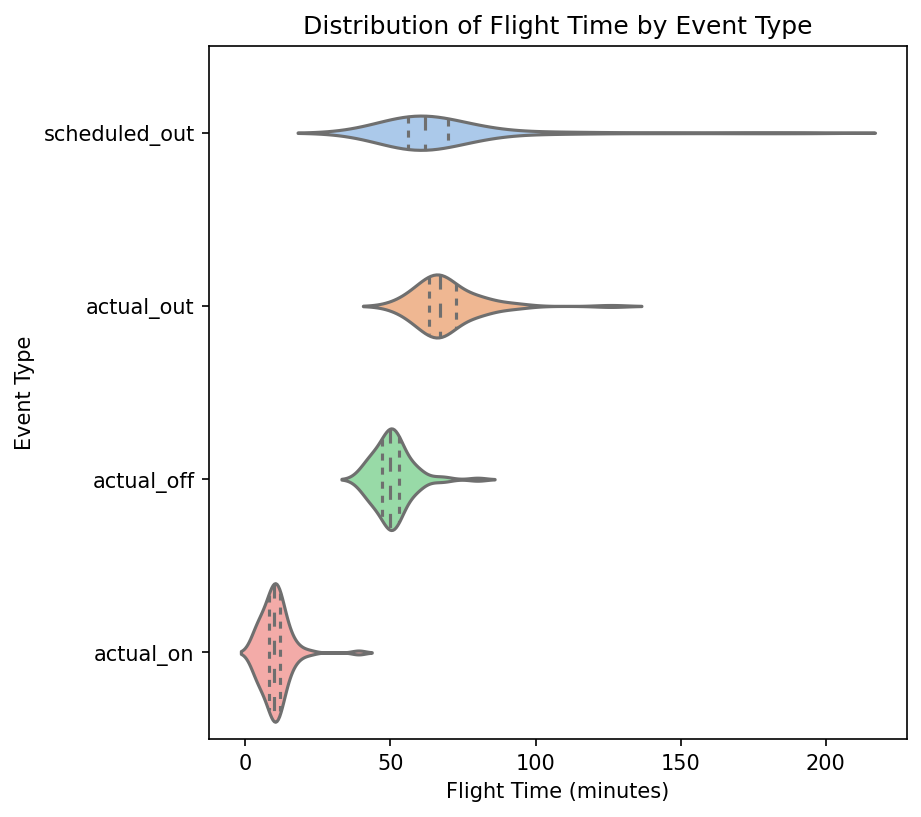

In [9]:
def plot_target_distribution(df, type='violin'):
    
    if type == 'violin':
        # Plotting the distribution of flight time by event type, with individual vertical plots
        plt.figure(figsize=(6, 6), dpi=150)
        sns.violinplot(data=df, y='event_type', x='target', inner='quartile', palette='pastel')
        plt.title('Distribution of Flight Time by Event Type')
        plt.ylabel('Event Type')
        plt.xlabel('Flight Time (minutes)')
        plt.show()

    if type == 'boxplot':
        plt.figure(figsize=(10, 12))
        sns.boxplot(data=df, y='event_type', x='target', palette='pastel')
        plt.title('Distribution of Flight Time by Event Type')
        plt.ylabel('Event Type')
        plt.xlabel('Flight Time (minutes)')
        plt.show()
        
        
plot_target_distribution(df.query('target < 250'), type='violin')

In [10]:
from pycaret.regression import *
ml_exp = setup(data=df[ALL_COLS], 
      target='target', 
      session_id=123, 
      # preprocess=True, 
      # custom_pipeline=[preprocessor],
      numeric_features = NUM_FEATURES,
      categorical_features = CAT_FEATURES,
      date_features = DATE_FEATURES,
      ignore_features = 'fa_flight_id',
      create_date_columns = ['hour','dayofweek'],
      outliers_threshold = 0.05,
      # feature_selection = True,
      # feature_selection_method = 'univariate',
      fold_strategy="groupkfold", 
      fold_groups= KFOLD_GROUP,
      # pca=True
      )


ModuleNotFoundError: No module named 'pycaret'

In [154]:
# lr = create_model('lr')

In [162]:
best_model = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,13.4527,647.7640,17.5515,-4.5321,0.2977,0.2464,0.1080
lar,Least Angle Regression,16.0963,604.8439,20.5395,-1.3040,0.5538,0.4125,0.1200
rf,Random Forest Regressor,18.8452,1003.3314,23.6036,-6.2701,0.3576,0.3558,0.1130
gbr,Gradient Boosting Regressor,18.9296,1069.9346,23.7907,-3.0634,0.3701,0.3688,0.1150
ridge,Ridge Regression,19.0647,894.0617,23.8357,-4.0533,0.4541,0.4669,0.1120
lasso,Lasso Regression,18.7434,926.0812,24.0063,-4.5204,0.4529,0.4240,0.1150
llar,Lasso Least Angle Regression,18.7434,926.0941,24.0065,-4.5206,0.4529,0.4240,0.1080
lr,Linear Regression,19.5756,907.7791,24.6950,-3.2805,0.5261,0.4525,0.1170
et,Extra Trees Regressor,19.1909,1049.6545,25.3527,-8.5058,0.3674,0.3486,0.1160
ada,AdaBoost Regressor,19.4924,1287.9780,26.8042,-9.7432,0.3692,0.3470,0.1140


In [163]:
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.9772,51.5138,7.1773,0.8734,0.2007,0.2065
1,11.2301,140.4319,11.8504,0.7176,0.3901,0.2713
2,14.9500,384.2370,19.6020,-0.1948,0.3381,0.3835
3,43.7336,4624.6735,68.0050,0.1997,0.5827,0.4093
4,2.5221,8.5894,2.9308,0.9849,0.1232,0.1094
5,8.1106,81.0579,9.0032,0.8548,0.5623,0.2824
6,4.5668,35.6001,5.9666,0.8839,0.2912,0.2868
7,1.9121,4.0185,2.0046,0.8865,0.0384,0.0371
8,27.6863,778.1215,27.8948,-47.6326,0.3346,0.2815


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [164]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [165]:
final_model = finalize_model(tuned_model)
final_model

Pipeline(memory=FastMemory(location=/var/folders/h9/5tcwr7tj1bz4bkm47lrggkhm0000gn/T/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['event_ts'],
                                    transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                  'dayofweek']))),
                ('numerical_imputer',
                 TransformerWrapper(include=['filed_airspeed'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['event_type'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['event_type'],
                                    transformer=OneHotEncoder(cols=['event_type'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator', HuberRegressor(fit_intercept=False))])

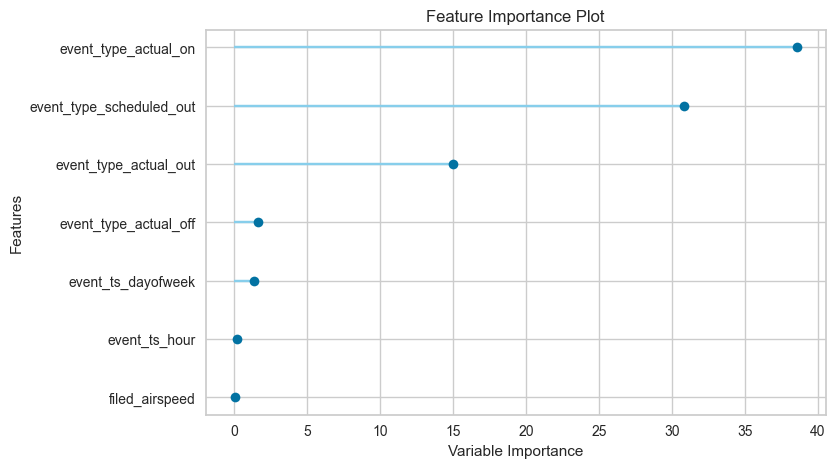

In [166]:
plot_model(tuned_model, plot = 'feature')


In [167]:
# deep_check(tuned_model)


In [168]:
pred_unseen = predict_model(tuned_model, data = df[ALL_COLS])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,17.9006,1773.0622,42.1077,0.3249,0.3971,0.2066


In [169]:
predict_model(tuned_model) # predict on holdout set

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,35.5175,4645.6413,68.1589,0.0285,0.5917,0.3070


,event_ts,event_type,filed_airspeed,target,prediction_label
25,2023-08-14 12:00:00,scheduled_out,481,55.000000,76.626603
48,2023-08-10 13:03:46,actual_on,482,39.233334,11.626461
28,2023-08-14 12:44:24,actual_on,481,10.600000,7.176162
40,2023-08-11 12:00:00,scheduled_out,482,171.000000,82.222571
32,2023-08-13 20:39:28,actual_off,483,53.533333,57.725509
47,2023-08-10 12:22:52,actual_off,482,80.133331,51.658409
51,2023-08-09 11:50:00,actual_out,482,66.000000,63.367735
56,2023-08-08 11:54:00,actual_out,482,81.000000,61.991094
52,2023-08-09 12:02:00,actual_off,482,54.000000,50.281768
10,2023-08-18 09:58:00,actual_out,464,80.000000,64.049790


In [174]:
!cat requirements.txt

deltalake== 0.10.0
gcsfs==2023.6.0
pandas==2.0.3
seaborn==0.12.2
matplotlib==3.7.2

In [181]:
!pip install google-cloud-aiplatform

  Using cached google_cloud_aiplatform-1.31.0-py2.py3-none-any.whl (2.8 MB)
  Using cached Shapely-1.8.5.post1-cp38-cp38-macosx_11_0_arm64.whl (1.1 MB)
  Using cached google_cloud_resource_manager-1.10.3-py2.py3-none-any.whl (320 kB)


In [ ]:


# # df.style.bar(subset=['target'], color='#d65f5f')

# def style_datframe(df):
#     def highlight_scheduled_out(row):
#         if row['event_type'] == 'scheduled_out':
#             return ['background-color: lightgreen; color: black'] * len(row)
#         return [''] * len(row)

#     # Apply the styling
#     return df.style.apply(highlight_scheduled_out, axis=1)

    